<a href="https://colab.research.google.com/github/niss10/IS-698-FL-Project/blob/main/FedCollab_FL_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisite - Environment Setup
1. Run the below cell
2. Then, RESTART the Colab runtime. (after succefull completion)
3. After Restarting don't run this cell

In [1]:

# Force‑reinstall NumPy and scikit‑learn
!pip install --upgrade --force-reinstall numpy==1.24.3 scikit-learn

# Install the CPU‑only PyTorch build
!pip uninstall -y torch torchvision
!pip install --index-url https://download.pytorch.org/whl/cpu torch torchvision

# Install/latest versions of Flower and PyTorch
!pip install --upgrade flwr pandas
!pip install -U "flwr[simulation]"

# Then, RESTART the Colab runtime.

# After Restarting don't run this cell

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.7/37.7 MB 10.1 MB/s eta 0:00:00
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.6.0
    Uninstalling threadpoolctl-3.6.0:
      Successfully uninstalled threadpoolctl-3.6.0
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: joblib
    Found existing installation: joblib 1.5.0
    Uninstalling joblib-1.5.0:
      Successfully uninstalled joblib-1.5.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.3
    Uninstalling scipy-1.15.3:
      Successfu

Found existing installation: torch 2.6.0+cu124
Uninstalling torch-2.6.0+cu124:
  Successfully uninstalled torch-2.6.0+cu124
Found existing installation: torchvision 0.21.0+cu124
Uninstalling torchvision-0.21.0+cu124:
  Successfully uninstalled torchvision-0.21.0+cu124
Looking in indexes: https://download.pytorch.org/whl/cpu
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.0/176.0 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.2/6.2 MB 94.6 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0+cpu which is incompatible.
torchaudio 2.6.0+cu124

## Import required libraries

In [1]:
# Import required libraries
import flwr as fl
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
from flwr.server.strategy import FedAvg
from flwr.client import NumPyClient
import matplotlib.pyplot as plt
import os
from pathlib import Path
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error, mean_squared_error

## Adding Master file
Setting source of truth file that we will use for federated learning simulation

In [2]:

# Adding Master dataset file
print("Please upload preprocessed_dataset.csv")
uploaded = files.upload()  # upload the downloaded preprocessed_dataset.csv
if(uploaded):
  print("File uploaded successfully")
else:
  print("File upload failed, Please upload again")
  uploaded = files.upload()

Please upload preprocessed_dataset.csv


Saving preprocessed_dataset.csv to preprocessed_dataset.csv
File uploaded successfully


# Data Partitioning for Client simulations

In [3]:
# Data Partitioning Utility

# Load the master preprocessed dataset.
def load_master(csv_path):
    return pd.read_csv(csv_path)

# Randomly select N different user from all
def sample_user_ids(df, num_clients, seed=42):
    user_ids = df["UserID"].unique()
    rng = np.random.default_rng(seed)
    if num_clients >= len(user_ids):
        return list(user_ids)
    return list(rng.choice(user_ids, size=num_clients, replace=False))

# Save each selected user's rating to out_dir/user_{uid}.csv
def partition_by_user(df, out_dir, user_ids=None):
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    if user_ids is None:
        user_ids = df["UserID"].unique()

    csv_paths = []
    for uid in user_ids:
        df_user = df[df["UserID"] == uid]
        path = out_path / f"user_{uid}.csv"
        df_user.to_csv(path, index=False)
        csv_paths.append(str(path))
    return csv_paths

## Sanity check data partioning

In [4]:

# Load the master dataset that we have uploaded earlier
MASTER_CSV = "preprocessed_dataset.csv"
df_master  = load_master(MASTER_CSV)
print("Rows:", len(df_master), " | Users:", df_master['UserID'].nunique(), " | Movie:", df_master['MovieID'].nunique())

# Cheking for 5 clients
paths_5   = partition_by_user(df_master, "clients_5",   sample_user_ids(df_master, 5))


print(f"5-client num files:   {len(paths_5)}")
print(f"5-client files:   {paths_5}")


<ipython-input-3-2292d8e7e956>:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path)


Rows: 1000209  | Users: 6040  | Movie: 3706
5-client num files:   5
5-client files:   ['clients_5/user_4673.csv', 'clients_5/user_2651.csv', 'clients_5/user_3953.csv', 'clients_5/user_539.csv', 'clients_5/user_2616.csv']


# Model & Local-Training Utilities

## Loading Local data and Train/Test Split

In [6]:
# Return train & test DataLoaders for one client CSV.
def load_client_data(csv_path, batch_size=32, test_size=0.2, seed=42):
    df = pd.read_csv(csv_path)
    users  = torch.tensor(df["UserID"].values,   dtype=torch.long)
    movies = torch.tensor(df["MovieID"].values,  dtype=torch.long)
    ratings= torch.tensor(df["Rating"].values,   dtype=torch.float32)

    idx = np.arange(len(df))
    rng = np.random.default_rng(seed)
    rng.shuffle(idx)
    split = int((1 - test_size) * len(idx))
    train_idx, test_idx = idx[:split], idx[split:]

    train_ds = TensorDataset(users[train_idx], movies[train_idx], ratings[train_idx])
    test_ds  = TensorDataset(users[test_idx],  movies[test_idx],  ratings[test_idx])

    return (DataLoader(train_ds, batch_size=batch_size, shuffle=True),
            DataLoader(test_ds,  batch_size=batch_size, shuffle=False))

## Model

In [7]:
# Defining RecommenderMLP Model using Pytorch

# User-embedding + Movie-embedding -> 2-layer MLP[64 -> ReLu] -> rating (1-5).
class RecommenderMLP(nn.Module):
    def __init__(self, num_users, num_movies,
                 embed_dim=32, hidden=64):
        super().__init__()
        self.user_embed  = nn.Embedding(num_users  + 1, embed_dim)
        self.movie_embed = nn.Embedding(num_movies + 1, embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim * 2, hidden),
            nn.ReLU(),
            nn.Linear(hidden, 1)
        )

    def forward(self, user_ids, movie_ids):
        u = self.user_embed(user_ids)
        m = self.movie_embed(movie_ids)
        x = torch.cat([u, m], dim=1)
        return self.mlp(x).squeeze(1)


## Training and Evaluation

In [8]:
# Utility for loading data into tensor for client and training and evalation

# this function will train Model for one epoch
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total, count = 0.0, 0
    for u, m, r in loader:
        u, m, r = u.to(device), m.to(device), r.to(device)
        optimizer.zero_grad()
        loss = criterion(model(u, m), r)
        loss.backward()
        optimizer.step()
        total += loss.item() * len(r)
        count += len(r)
    return total / count

# Evaluate train model on test dataset and return loss
def evaluate(model, loader, criterion, device):
    model.eval()
    total, count = 0.0, 0
    with torch.no_grad():
        for u, m, r in loader:
            u, m, r = u.to(device), m.to(device), r.to(device)
            loss = criterion(model(u, m), r)
            total += loss.item() * len(r)
            count += len(r)
    return total / count

## Quick Sanity Check of Model

In [9]:
# running model for 1 user from 5 client we have created to check how it works
sample_csv = "clients_5/" + sorted(os.listdir("clients_5"))[0]

# Get dataset dimensions for embeddings
num_users  = df_master["UserID"].max()
num_movies = df_master["MovieID"].max()

# Build loaders and model
train_loader, test_loader = load_client_data(sample_csv, batch_size=16)
device = torch.device("cpu")
model  = RecommenderMLP(num_users, num_movies).to(device)

opt  = torch.optim.Adam(model.parameters(), lr=1e-3)
crit = torch.nn.MSELoss()

Train_loss = train_one_epoch(model, train_loader, opt, crit, device)
Test_loss  = evaluate(model, test_loader, crit, device)

print("Train loss:", Train_loss)
print("Test  loss:", Test_loss)


Train loss: 11.64303970336914
Test  loss: 12.205503463745117


# Federated Learning with DP

In [10]:
# ---------- Manual DP Implementation ----------
import os, numpy as np, torch, flwr as fl
from flwr.server.strategy import FedAvg
import matplotlib.pyplot as plt
from math import sqrt, log

# Run a FedAvg simulation for <num_clients> clients over <num_rounds>.
# Returns Flower history for later analysis.
def run_federated(
    df_master,
    num_clients: int,
    num_rounds: int,
    local_epochs: int,
    batch_size: int = 32,
    seed: int = 42,
    dp_epsilon: float = 5.0,     # Privacy budget
    dp_delta: float = 1e-5,      # Privacy failure probability
    dp_clip_norm: float = 5.0,   # Gradient clipping threshold
):
    # Pick or use all user IDs
    user_pool   = df_master["UserID"].unique()
    chosen_uids = (
        user_pool
        if num_clients >= len(user_pool)
        else sample_user_ids(df_master, num_clients, seed)
    )

    #  Ensure client CSVs exist
    folder = f"clients_{num_clients}"
    if not os.path.isdir(folder) or len(os.listdir(folder)) < len(chosen_uids):
        print(f"Creating {folder}/ ...")
        partition_by_user(df_master, folder, chosen_uids)
    csv_paths = sorted(os.path.join(folder, f"user_{uid}.csv") for uid in chosen_uids)

    # Create client_fn
    num_users  = int(df_master["UserID"].max())
    num_movies = int(df_master["MovieID"].max())

    def client_fn(cid: str):
        idx  = int(cid)
        csv  = csv_paths[idx]          # csv_paths must be defined outside
        tr, te = load_client_data(csv, batch_size=batch_size)
        model  = RecommenderMLP(num_users, num_movies)

        # Calculate noise multiplier using the privacy budget and based on DP-SGD
        # smaller values mean more privacy but less utility
        # estimated_iterations - Approx total number of gradient updates

        estimated_iterations = len(tr) * local_epochs * num_rounds  # multiple epochs
        noise_multiplier = calculate_noise_multiplier(dp_epsilon, dp_delta, estimated_iterations)

        return FLClientWithDP(
            model, tr, te,
            device=torch.device("cpu"),
            noise_multiplier=noise_multiplier,
            max_grad_norm=dp_clip_norm,
        )

    # FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,
        fraction_evaluate=1.0,
        min_fit_clients=num_clients,
        min_evaluate_clients=num_clients,
        min_available_clients=num_clients,
        on_fit_config_fn=lambda server_round: {"epochs": local_epochs}
    )

    # Run simulation
    print(f"\nStarting federated learning with {num_clients} clients:")
    print(f"- {num_rounds} federation rounds")
    print(f"- {local_epochs} local epochs per client per round")
    print(f"- Privacy budget: ε={dp_epsilon}, δ={dp_delta}, Clip norm: {dp_clip_norm}\n")

    history = fl.simulation.start_simulation(
        client_fn        = client_fn,
        num_clients      = num_clients,
        strategy         = strategy,
        config           = fl.server.ServerConfig(num_rounds=num_rounds),
        client_resources = {"num_cpus": 1},
    )

    # Report metrics
    print(f"\nFederated results for {num_clients} clients with Differential Privacy:")
    print(f"Privacy budget: ε={dp_epsilon}, δ={dp_delta}, Clip norm: {dp_clip_norm}\n")
    mse_values = []
    rmse_values = []

    for r, mse in history.losses_distributed:
          print(f"Round {r:02d}:  MSE={mse:8.4f}   RMSE={np.sqrt(mse):6.4f}")
          mse_values.append(mse)
          rmse_values.append(np.sqrt(mse))
    return  history, mse_values, rmse_values

def calculate_noise_multiplier(epsilon, delta, iterations):
    # Calculate noise value for DP-SGD based on privacy parameters
    # simple approximate formula

    c = np.sqrt(2 * np.log(1.25 / delta))
    comp_factor = np.sqrt(2 * np.log(1/delta) * iterations)
    effe_epsilon = epsilon / comp_factor

    # Calculate noise multiplier
    noise_multiplier = c / effe_epsilon

    return noise_multiplier

# Flower client wrapper with manual DP
class FLClientWithDP(fl.client.NumPyClient):
    def __init__(self, model, train_loader, test_loader, device,
                 noise_multiplier=1.0, max_grad_norm=1.0):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.device = device
        self.criterion = torch.nn.MSELoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        # Privacy parameters
        self.noise_multiplier = noise_multiplier
        self.max_grad_norm = max_grad_norm

        self.losses_train = []
        self.losses_test = []

    def get_parameters(self, config):
        return [p.cpu().numpy() for p in self.model.state_dict().values()]

    def set_parameters(self, params):
        keys = list(self.model.state_dict().keys())
        self.model.load_state_dict({k: torch.tensor(v) for k, v in zip(keys, params)}, strict=True)

    def fit(self, params, config):
        self.set_parameters(params)
        self.model.train()
        total_loss = 0.0

        # Training loop with manual differential privacy
        for batch_idx, (user, item, rating) in enumerate(self.train_loader):
            user = user.to(self.device)
            item = item.to(self.device)
            rating = rating.to(self.device)

            self.optimizer.zero_grad()
            output = self.model(user, item)
            loss = self.criterion(output, rating)
            loss.backward()

            # 1. Clip gradients for DP
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), self.max_grad_norm)

            # 2. Add noise to gradients
            for p in self.model.parameters():
                if p.requires_grad and p.grad is not None:
                  noise = torch.randn_like(p.grad) * self.noise_multiplier * self.max_grad_norm
                  #print("Gradient before noise:", p.grad)  # Print gradient before
                  p.grad += noise
                  #print("Gradient after noise:", p.grad)   # Print gradient after
                  #print("Noise:", noise)

            self.optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(self.train_loader)

        # Save current train loss
        self.losses_train.append(avg_loss)

        # Evaluate on test data
        self.model.eval()
        eval_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for user, item, rating in self.test_loader:
                user, item, rating = user.to(self.device), item.to(self.device), rating.to(self.device)
                outputs = self.model(user, item)
                loss = self.criterion(outputs, rating)
                eval_loss += loss.item() * user.size(0)
                total_samples += user.size(0)

        avg_eval_loss = eval_loss / total_samples if total_samples > 0 else float('inf')
        self.losses_test.append(avg_eval_loss)

        print(f"Client training - Train loss: {avg_loss:.4f}, Test loss: {avg_eval_loss:.4f}")

        metrics = {
            "train_loss": float(avg_loss),
            "eval_loss": float(avg_eval_loss)
        }

        return self.get_parameters(config), len(self.train_loader.dataset), metrics

    def evaluate(self, param, config):
        self.set_parameters(param)
        self.model.eval()
        total_loss = 0.0
        total_samples = 0

        with torch.no_grad():
            for user, item, rating in self.test_loader:
                user, item, rating = user.to(self.device), item.to(self.device), rating.to(self.device)
                outputs = self.model(user, item)
                loss = self.criterion(outputs, rating)
                total_loss += loss.item() * user.size(0)
                total_samples += user.size(0)

        avg_loss = total_loss / total_samples
        return float(avg_loss), total_samples, {"eval_loss": float(avg_loss)}

In [11]:
!pip install opacus

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.7/251.7 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 52.5 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.6
    Uninstalling numpy-2.2.6:
      Successfully uninstalled numpy-2.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.
fastai 2.7.19 requires torch<2.7,>=1.10, but you have torch 2.7.0+cpu which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.7 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


# Triggering Federated Learning

In [12]:
# Load master once (if not in memory)
master_csv = "preprocessed_dataset.csv"

# Paramert for FL project, Configurable
num_clients = 100
num_rounds = 10
local_epochs = 3

df_master = load_master(master_csv)

# sanity run
history, mse_values, rmse_values = run_federated(df_master, num_clients=num_clients, num_rounds=num_rounds, local_epochs=local_epochs)

<ipython-input-3-2292d8e7e956>:5: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(csv_path)


Creating clients_100/ ...


	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
	Instead, use the `flwr run` CLI command to start a local simulation in your Flower app, as shown for example below:

		$ flwr new  # Create a new Flower app from a template

		$ flwr run  # Run the Flower app in Simulation Mode

	Using `start_simulation()` is deprecated.

            This is a deprecated feature. It will be removed
            entirely in future versions of Flower.
        
INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout



Starting federated learning with 100 clients:
- 10 federation rounds
- 3 local epochs per client per round
- Privacy budget: ε=5.0, δ=1e-05, Clip norm: 5.0



2025-05-19 22:12:50,599	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'CPU': 2.0, 'node:__internal_head__': 1.0, 'node:172.28.0.12': 1.0, 'object_store_memory': 3996191539.0, 'memory': 7992383079.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 2 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
(pid=9432) 2025-05-19 22:12:57.146065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
(pid=9432) WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
(pid=9432) E0000 00:00:1747692777.187448    9432 cuda_dnn.cc:8310] U

(ClientAppActor pid=9432) Client training - Train loss: 15.6433, Test loss: 15.6497
(ClientAppActor pid=9432) Client training - Train loss: 18.0171, Test loss: 17.7905


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common i

(ClientAppActor pid=9432) Client training - Train loss: 11.2421, Test loss: 10.4974


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common i

(ClientAppActor pid=9432) Client training - Train loss: 12.1484, Test loss: 12.4295


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 17.1499, Test loss: 17.6264
(ClientAppActor pid=9432) Client training - Train loss: 11.4715, Test loss: 12.4824


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 15.6585, Test loss: 14.6467
(ClientAppActor pid=9432) Client training - Train loss: 17.4413, Test loss: 18.4772


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common i

(ClientAppActor pid=9432) Client training - Train loss: 12.0357, Test loss: 8.3169
(ClientAppActor pid=9432) Client training - Train loss: 14.2132, Test loss: 14.9858


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common i

(ClientAppActor pid=9432) Client training - Train loss: 16.2029, Test loss: 17.6808
(ClientAppActor pid=9432) Client training - Train loss: 12.4696, Test loss: 14.3830


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 15.0828, Test loss: 14.0459
(ClientAppActor pid=9432) Client training - Train loss: 15.6250, Test loss: 14.5074


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common i

(ClientAppActor pid=9432) Client training - Train loss: 16.9643, Test loss: 19.7859
(ClientAppActor pid=9432) Client training - Train loss: 13.6630, Test loss: 14.1617


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common i

(ClientAppActor pid=9432) Client training - Train loss: 13.7415, Test loss: 12.9730


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common i

(ClientAppActor pid=9432) Client training - Train loss: 15.8773, Test loss: 12.6607
(ClientAppActor pid=9432) Client training - Train loss: 17.3419, Test loss: 17.1114


(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 16.3085, Test loss: 16.9195
(ClientAppActor pid=9432) Client training - Train loss: 12.1039, Test loss: 14.1319


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common i

(ClientAppActor pid=9432) Client training - Train loss: 9.1096, Test loss: 11.9167
(ClientAppActor pid=9432) Client training - Train loss: 19.0109, Test loss: 18.9689


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common i

(ClientAppActor pid=9432) Client training - Train loss: 17.0716, Test loss: 18.2966
(ClientAppActor pid=9432) Client training - Train loss: 14.1660, Test loss: 13.9003


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance

(ClientAppActor pid=9432) Client training - Train loss: 18.8963, Test loss: 19.5545
(ClientAppActor pid=9432) Client training - Train loss: 14.7170, Test loss: 15.4415


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 15.1531, Test loss: 14.2033
(ClientAppActor pid=9432) Client training - Train loss: 19.7096, Test loss: 20.0737


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 20.0224, Test loss: 20.2936
(ClientAppActor pid=9432) Client training - Train loss: 14.3149, Test loss: 12.8898


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 19.6334, Test loss: 22.2183
(ClientAppActor pid=9432) Client training - Train loss: 19.7521, Test loss: 20.5990


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 16.2000, Test loss: 14.5362
(ClientAppActor pid=9432) Client training - Train loss: 24.5213, Test loss: 19.7204


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 14.6004, Test loss: 12.9821
(ClientAppActor pid=9432) Client training - Train loss: 11.9362, Test loss: 12.3899
(ClientAppActor pid=9432) Client training - Train loss: 17.5377, Test loss: 20.4924


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


(ClientAppActor pid=9432) Client training - Train loss: 12.4088, Test loss: 13.8419
(ClientAppActor pid=9432) Client training - Train loss: 17.4181, Test loss: 16.6953


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         


(ClientAppActor pid=9432) Client training - Train loss: 11.5622, Test loss: 11.6371
(ClientAppActor pid=9432) Client training - Train loss: 11.8233, Test loss: 17.7876


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The 

(ClientAppActor pid=9432) Client training - Train loss: 12.6227, Test loss: 12.0683 [repeated 35x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientA

(ClientAppActor pid=9431) Client training - Train loss: 18.7491, Test loss: 20.6314 [repeated 24x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 93x across cluster]
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=94

(ClientAppActor pid=9431) Client training - Train loss: 15.7649, Test loss: 16.0777 [repeated 54x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 50x across cluster]
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=94

(ClientAppActor pid=9432) Client training - Train loss: 14.1666, Test loss: 16.3675 [repeated 35x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 38x across cluster]
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAp

(ClientAppActor pid=9431) Client training - Train loss: 11.8224, Test loss: 17.7596 [repeated 11x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientA

(ClientAppActor pid=9432) Client training - Train loss: 16.0735, Test loss: 14.0493 [repeated 45x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientA

(ClientAppActor pid=9431) Client training - Train loss: 15.9822, Test loss: 14.5155 [repeated 45x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)     

(ClientAppActor pid=9432) Client training - Train loss: 17.0950, Test loss: 17.8870 [repeated 10x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 74x across cluster]
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed [repeated 74x across cluster]
(ClientAppActor pid=9432)             entirely in future versions of Flower. [repe

(ClientAppActor pid=9432) Client training - Train loss: 15.6826, Test loss: 14.5571 [repeated 37x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 34x across cluster]
(ClientAppActor pid=9431)             This is a deprecated feature. It will be removed [repeated 34x across cluster]
(ClientAppActor pid=9431)             entirely in future versions of Flower. [repeated 34x across cluster]
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientApp

(ClientAppActor pid=9432) Client training - Train loss: 17.2157, Test loss: 16.2848 [repeated 51x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 54x across cluster]
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed [repeated 54x across cluster]
(ClientAppActor pid=9432)             entirely in future versions of Flower. [repeated 54x across cluster]
(ClientAppActor pid=9431) 
(ClientApp

(ClientAppActor pid=9432) Client training - Train loss: 17.0940, Test loss: 9.9096 [repeated 12x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 79x across cluster]
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=94

(ClientAppActor pid=9432) Client training - Train loss: 13.3982, Test loss: 16.8478 [repeated 39x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`. [repeated 43x across cluster]
(ClientAppActor pid=9432) 
(ClientAppActor pid=94

(ClientAppActor pid=9431) Client training - Train loss: 16.9903, Test loss: 19.7392 [repeated 55x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`

(ClientAppActor pid=9432) Client training - Train loss: 11.8103, Test loss: 17.7678 [repeated 6x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientA

(ClientAppActor pid=9431) Client training - Train loss: 14.0446, Test loss: 12.8841 [repeated 52x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientA

(ClientAppActor pid=9432) Client training - Train loss: 14.3693, Test loss: 12.5783 [repeated 48x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 62x across cluster]
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed [repeated 62x across cluster]
(ClientAppActor pid=9432)             entirely in future versions of Flower. [repeated 62x across cluster]
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientApp

(ClientAppActor pid=9431) Client training - Train loss: 19.2507, Test loss: 17.1776 [repeated 35x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 42x across cluster]
(ClientAppAct

(ClientAppActor pid=9432) Client training - Train loss: 12.0081, Test loss: 8.2430 [repeated 48x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 41x across cluster]
(ClientAppActor pid=9431)             This is a deprecated feature. It will be removed [repeated 41x across cluster]
(ClientAppActor pid=9431)             entirely in future versions of Flower. [repeated 41x across cluster]
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientApp

(ClientAppActor pid=9431) Client training - Train loss: 14.8307, Test loss: 14.1237 [repeated 17x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientA

(ClientAppActor pid=9431) Client training - Train loss: 25.4505, Test loss: 19.7318 [repeated 60x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientA

(ClientAppActor pid=9432) Client training - Train loss: 18.9767, Test loss: 16.5050 [repeated 29x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)     

(ClientAppActor pid=9431) Client training - Train loss: 15.1305, Test loss: 14.6362 [repeated 11x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.comm

(ClientAppActor pid=9431) Client training - Train loss: 12.8481, Test loss: 16.7990 [repeated 48x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 44x across cluster]
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed [repeated 44x across cluster]
(ClientAppActor pid=9432)             entirely in future versions of Flower. [repe

(ClientAppActor pid=9432) Client training - Train loss: 13.4522, Test loss: 14.9756 [repeated 40x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
INFO :      aggregate_fit: received 100 results and 0 failures
INFO :      configure_evaluate: strategy sampled 100 clients (out of 100)
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE:

(ClientAppActor pid=9432) Client training - Train loss: 14.0222, Test loss: 16.2352 [repeated 12x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 100x across cluster]
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed [repeated 100x across cluster]
(ClientAppActor pid=9432)             entirely in future versions of Flower. [repeated 100x across cluster]
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(Client

(ClientAppActor pid=9432) Client training - Train loss: 18.0195, Test loss: 16.6174 [repeated 37x across cluster]


(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 37x across cluster]
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed [repeated 37x across cluster]
(ClientAppActor pid=9432)             entirely in future versions of Flower. [repeated 37x across cluster]
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientApp

(ClientAppActor pid=9432) Client training - Train loss: 10.8754, Test loss: 11.8002 [repeated 52x across cluster]


(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context` [repeated 52x across cluster]
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed [repeated 52x across cluster]
(ClientAppActor pid=9432)             entirely in future versions of Flower. [repeated 52x across cluster]
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)         
(ClientAppActor pid=9431) 
(ClientAppActor pid=9431)         
(ClientAppActor pid=9432) 
(ClientApp


Federated results for 100 clients with Differential Privacy:
Privacy budget: ε=5.0, δ=1e-05, Clip norm: 5.0

Round 01:  MSE= 13.7163   RMSE=3.7035
Round 02:  MSE= 13.7241   RMSE=3.7046
Round 03:  MSE= 13.7118   RMSE=3.7029
Round 04:  MSE= 13.7062   RMSE=3.7022
Round 05:  MSE= 13.6927   RMSE=3.7004
Round 06:  MSE= 13.6764   RMSE=3.6982
Round 07:  MSE= 13.6807   RMSE=3.6987
Round 08:  MSE= 13.6772   RMSE=3.6983
Round 09:  MSE= 13.6811   RMSE=3.6988
Round 10:  MSE= 13.6696   RMSE=3.6972


(ClientAppActor pid=9432) WARNING :   DEPRECATED FEATURE: `client_fn` now expects a signature `def client_fn(context: Context)`.The provided `client_fn` has signature: {'cid': <Parameter "cid: str">}. You can import the `Context` like this: `from flwr.common import Context`
(ClientAppActor pid=9432) 
(ClientAppActor pid=9432)             This is a deprecated feature. It will be removed
(ClientAppActor pid=9432)             entirely in future versions of Flower.
(ClientAppActor pid=9432)         
(ClientAppActor pid=9432) WARNING :   Deprecation Warning: The `client_fn` function must return an instance of `Client`, but an instance of `NumpyClient` was returned. Please use `NumPyClient.to_client()` method to convert it to `Client`.


# Visulization

<ipython-input-13-ee59740190bd>:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--o" (-> color='b'). The keyword argument will take precedence.
  plt.plot(rounds, mse_values, 'b--o', color ='blue', label='MSE Loss')
<ipython-input-13-ee59740190bd>:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-s" (-> color='r'). The keyword argument will take precedence.
  plt.plot(rounds, rmse_values, 'r-s', color ='orange', label='RMSE')


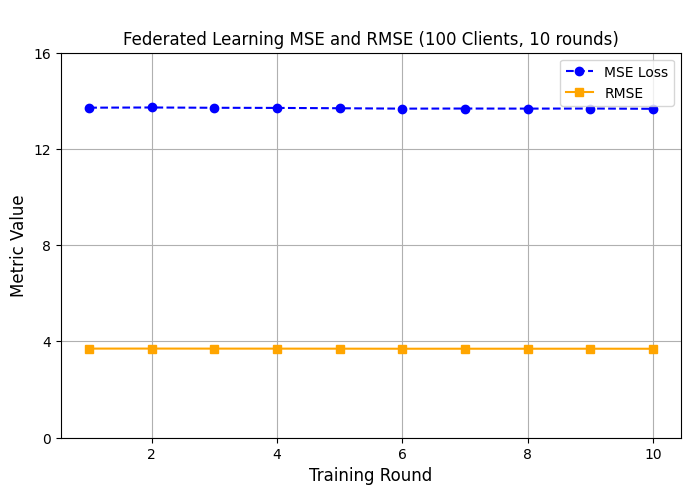

In [13]:
rounds = range(1, num_rounds + 1)

plt.figure(figsize=(8, 5))

plt.plot(rounds, mse_values, 'b--o', color ='blue', label='MSE Loss')
plt.plot(rounds, rmse_values, 'r-s', color ='orange', label='RMSE')

max_y = max(max(mse_values), max(rmse_values))
y_ticks = np.arange(0, max_y + 4, 4)  # Start at 0, end at max_y + 4, step by 4
y_ticks
plt.yticks(y_ticks)

plt.title(f'\nFederated Learning MSE and RMSE ({num_clients} Clients, {num_rounds} rounds)')
plt.xlabel("Training Round", fontsize=12)
plt.ylabel("Metric Value", fontsize=12)

plt.legend()
plt.grid(True)
plt.show()